## Loading Libreries

# 2. Data Acquisition and Cleaning

First we load some of the libraries we'll need:

In [351]:
import numpy as np
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import sklearn

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## 2.1. Amsterdam Neighbourhoods

From the Kellog dataset (https://www.kaggle.com/erikbruin/airbnb-amsterdam) we extract data about Amsterdam Neighborhoods. This dataset has several Airbnb available appartments. We'll only use the geographical coordinates (latitude and longitude) to compute the neighbourhood coordinates.

In [352]:
amsterdam_listings = pd.read_csv('listings.csv')
amsterdam_listings.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,NaN,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,NaN,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198


By grouping the appartments per Neighbourhood and averaging their geographical coordinate, we build a dataframe with all neighborhoods in Amsterdam and their location:

In [360]:
# dataframe with all neighborhoods in Amsterdam and their geographic coordinates
df_amsterdam_neighbourhood = amsterdam_listings.groupby('neighbourhood')[['latitude', 'longitude']].mean()
df_amsterdam_neighbourhood.reset_index(inplace=True)
df_amsterdam_neighbourhood

,neighbourhood,latitude,longitude
0,Bijlmer-Centrum,52.318004,4.950052
1,Bijlmer-Oost,52.321051,4.975663
2,Bos en Lommer,52.378620,4.852084
3,Buitenveldert - Zuidas,52.330604,4.871797
4,Centrum-Oost,52.365962,4.903332
5,Centrum-West,52.375600,4.887150
6,De Aker - Nieuw Sloten,52.345349,4.797822
7,De Baarsjes - Oud-West,52.366136,4.862588
8,De Pijp - Rivierenbuurt,52.351150,4.897441
9,Gaasperdam - Driemond,52.300510,4.984249


## 2.2. Amsterdam Restaurants

Now, we're going to use Foursquare API for each Neighborhood in the city to retrieve basic information about restaurants in the city.

In [355]:
## Preparing Foursquare
CLIENT_ID = 'KR4Q154WR4YGD01Q1SOSMWEKKH1WNUXNIIWLHJ1ZZVPY5UIK' # your Foursquare ID
CLIENT_SECRET = 'B2IFOOL0C2YJ0MO2KFYZR2Z0NHMFGKHAYCGNH02ELHGULQTM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

This function retrieves basic information about venues nerby a given location.

In [356]:
def get_venues_4sq(CLIENT_ID, CLIENT_SECRET, latitude, longitude, section = 'food', limit = 100, radius = 500):
# request a list of venues based on a location
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit,
        section)
    url # display URL
    return(requests.get(url).json())

In [357]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [372]:
# Getting venues information for all neighborhoods in Amsterdam

venues_list = pd.DataFrame()
b = 0
e = 22

#for neighbourhood, latitude, longitude in zip(df_amsterdam_neighbourhood['neighbourhood'][b:e], df_amsterdam_neighbourhood['latitude'][b:e], df_amsterdam_neighbourhood['longitude'][b:e]):
for neighbourhood, latitude, longitude in zip(df_amsterdam_neighbourhood['neighbourhood'][b:e], latitude, longitude):
    print('{} - {} : {}'.format(neighbourhood, latitude,  longitude))
    # requests venues for the neighbourhood
    results = get_venues_4sq(CLIENT_ID, CLIENT_SECRET, latitude, longitude, limit = 1000, radius = 300)
    # parse the result
    nearby_venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(nearby_venues) # flatten JSON
    # filter columns
    filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues[filtered_columns]
    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues['neighbourhood'] = neighbourhood
    venues_list = pd.concat([venues_list, nearby_venues], ignore_index=True)
    

TypeError: 'float' object is not iterable

In [379]:
venues_list.head()

,id,name,categories,lat,lng,neighbourhood,details,likes
0,4b45ca45f964a520601026e3,Pasta di Mamma,Italian Restaurant,52.314779,4.955087,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a8d9...","{'meta': {'code': 200, 'requestId': '5ebe4c689..."
1,4a27db80f964a52026941fe3,Kam Yin,Chinese Restaurant,52.315535,4.955318,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a7e9...","{'meta': {'code': 200, 'requestId': '5ebe4c9f9..."
2,55199479498eb5350aa6a7ce,World Of Food,Food Court,52.322949,4.956306,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a5fe...","{'meta': {'code': 200, 'requestId': '5ebe4c19a..."
3,595239a04f0e58127fc9fd79,Coffee Fellows,Café,52.314845,4.953943,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe498a6...","{'meta': {'code': 200, 'requestId': '5ebe4c964..."
4,4a27053ef964a52046871fe3,Deli Company,Deli / Bodega,52.313277,4.950251,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe49ed2...","{'meta': {'code': 200, 'requestId': '5ebe4d3ad..."


Because of the radius of 1000 m, the same venue can be fetched for several naighbourhoods, specially in center areas. To fix this, we are going to drop duplicates.

In [897]:
# if different values, we have duplicates
print(venues_list['id'].shape[0])
print(len(venues_list['id'].unique()))

1251
1159


In [898]:
for id in venues_list['id'].unique():
    d_indx = venues_list[venues_list['id'] == id].index
    venues_list.drop(index = d_indx[1:], inplace = True)
venues_list.reset_index(inplace=True, drop = True)  

# if different values, we have duplicates
print(venues_list['id'].shape[0])
print(len(venues_list['id'].unique()))

1159
1159


### 2.3. Retrieving more detail about the restaurants

Now, let's get more details about the restaurants. We are going to use Pirce Range and Category as variables for the Content-Based algorithm. As you might have noticed, we had already retrieved restaurant Category with the "get_venues_4sq" function. However, after checking venue details, I found another Category field with a list of more detailed information (a list of categories for each venue). We will use this information later on.

In [69]:
# venue details
# Premium Call!!!!
def get_venues_details_4sq(CLIENT_ID, CLIENT_SECRET, VENUE_ID, LIMIT = 100):
    # request a venues details
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        VENUE_ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    return(requests.get(url).json())

Retrieving and storing the data:

In [70]:
detail_list = []
i = 0
for venue_id in venues_list['id']:
    i += 1
    repeat = 0
    print('{} / {}'.format(i,venues_list.shape[0]))
    detail = {}
    while repeat < 5:
        try:            
            detail = get_venues_details_4sq(CLIENT_ID, CLIENT_SECRET, venue_id, LIMIT = 1000)
            repeat = 5
        except:
            repeat += 1
            print('Error in {}'.format(i))
    detail_list.append(detail)
    

1 / 43
2 / 43
3 / 43
4 / 43
5 / 43
6 / 43
7 / 43
8 / 43
9 / 43
10 / 43
11 / 43
12 / 43
13 / 43
14 / 43
15 / 43
16 / 43
17 / 43
18 / 43
19 / 43
20 / 43
21 / 43
22 / 43
23 / 43
24 / 43
25 / 43
26 / 43
27 / 43
28 / 43
29 / 43
30 / 43
31 / 43
32 / 43
33 / 43
34 / 43
35 / 43
36 / 43
37 / 43
38 / 43
39 / 43
40 / 43
41 / 43
42 / 43
43 / 43


In [71]:
venues_list['details'] = detail_list

### 2.4. etrieving users that liked each restaurant

Finally, we retrieve a list of users who liked each restaurant in our dataframe:

In [72]:
def get_venues_likes_4sq(CLIENT_ID, CLIENT_SECRET, VENUE_ID, LIMIT = 100):
    # This function returns a list of users that liked a given restaurant.
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}&limit={}'.format(
    VENUE_ID,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    LIMIT)
    return(requests.get(url).json())

In [73]:
# Getting venues likes for each venue in Amsterdam
likes_list = []
i = 0
for venue_id in venues_list['id']:
    i += 1
    repeat = 0
    print('{} / {}'.format(i,venues_list.shape[0]))
    likes = {}
    while repeat < 5:
        try:            
            likes = get_venues_likes_4sq(CLIENT_ID, CLIENT_SECRET, venue_id, LIMIT = 1000)
            print('Likes -> {}'.format(likes['response']['likes']['count']))
            repeat = 5
        except:
            repeat += 1
            print('Error in {}'.format(i))
    likes_list.append(likes)
    

1 / 43
Likes -> 81
2 / 43
Likes -> 187
3 / 43
Likes -> 30
4 / 43
Likes -> 348
5 / 43
Likes -> 18
6 / 43
Likes -> 49
7 / 43
Likes -> 6
8 / 43
Likes -> 315
9 / 43
Likes -> 19
10 / 43
Likes -> 162
11 / 43
Likes -> 24
12 / 43
Likes -> 40
13 / 43
Likes -> 24
14 / 43
Likes -> 69
15 / 43
Likes -> 17
16 / 43
Likes -> 36
17 / 43
Likes -> 20
18 / 43
Likes -> 102
19 / 43
Likes -> 5
20 / 43
Likes -> 15
21 / 43
Likes -> 12
22 / 43
Likes -> 10
23 / 43
Likes -> 8
24 / 43
Likes -> 10
25 / 43
Likes -> 6
26 / 43
Likes -> 7
27 / 43
Likes -> 12
28 / 43
Likes -> 6
29 / 43
Likes -> 4
30 / 43
Likes -> 22
31 / 43
Likes -> 17
32 / 43
Likes -> 12
33 / 43
Likes -> 87
34 / 43
Likes -> 44
35 / 43
Likes -> 11
36 / 43
Likes -> 36
37 / 43
Likes -> 5
38 / 43
Likes -> 21
39 / 43
Likes -> 12
40 / 43
Likes -> 6
41 / 43
Likes -> 1
42 / 43
Likes -> 2
43 / 43
Likes -> 4


In [74]:
venues_list['likes'] = likes_list


In [383]:
venues_list.head(3)

,id,name,categories,lat,lng,neighbourhood,details,likes
0,4b45ca45f964a520601026e3,Pasta di Mamma,Italian Restaurant,52.314779,4.955087,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a8d9...","{'meta': {'code': 200, 'requestId': '5ebe4c689..."
1,4a27db80f964a52026941fe3,Kam Yin,Chinese Restaurant,52.315535,4.955318,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a7e9...","{'meta': {'code': 200, 'requestId': '5ebe4c9f9..."
2,55199479498eb5350aa6a7ce,World Of Food,Food Court,52.322949,4.956306,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a5fe...","{'meta': {'code': 200, 'requestId': '5ebe4c19a..."


### 2.5. Saving Dataframe

In [3]:
def load_parse_file(file_name):
    # Loading,parsing and appending new parts to the venue list
    # loading saved venues
    venues_list_file = pd.read_csv(file_name)
    # Casting str into dict
    import ast
    temp1 = []
    temp2 = []
    for index in venues_list_file.index:
        temp1.append(ast.literal_eval(venues_list_file['details'][index]))
        temp2.append(ast.literal_eval(venues_list_file['likes'][index]))
    venues_list_file['details'] = temp1
    venues_list_file['likes'] = temp2
    return(venues_list_file)

In [4]:
def append_file(new_content, file_name, save = True):
    # Appending new content
    file_content = load_parse_file(file_name)
    file_content = file_content.append(new_content)
    if save:
        file_content.to_csv('venues_list.csv', index = False)
    return(file_content)

In [77]:
#new_venues_list = venues_list_c[2:5]
#new_venues_list
new_venues_list = venues_list.copy()
venues_list_c = venues_list.copy()
#venues_list.to_csv('venues_list.csv', index = False)

In [78]:
file_name = 'venues_list.csv'
append_file(new_venues_list, file_name)
content = load_parse_file(file_name)
content

,id,name,categories,lat,lng,neighbourhood,details,likes
0,4b45ca45f964a520601026e3,Pasta di Mamma,Italian Restaurant,52.314779,4.955087,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a8d9...","{'meta': {'code': 200, 'requestId': '5ebe4c689..."
1,4a27db80f964a52026941fe3,Kam Yin,Chinese Restaurant,52.315535,4.955318,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a7e9...","{'meta': {'code': 200, 'requestId': '5ebe4c9f9..."
2,55199479498eb5350aa6a7ce,World Of Food,Food Court,52.322949,4.956306,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a5fe...","{'meta': {'code': 200, 'requestId': '5ebe4c19a..."
3,595239a04f0e58127fc9fd79,Coffee Fellows,Café,52.314845,4.953943,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe498a6...","{'meta': {'code': 200, 'requestId': '5ebe4c964..."
4,4a27053ef964a52046871fe3,Deli Company,Deli / Bodega,52.313277,4.950251,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe49ed2...","{'meta': {'code': 200, 'requestId': '5ebe4d3ad..."
...,...,...,...,...,...,...,...,...
1246,58555c3dd8f3e92d76421508,Salsa Shop,Burrito Place,52.366295,4.868607,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec123e39...","{'meta': {'code': 200, 'requestId': '5ec125230..."
1247,5b2155021af852002c3bfda6,Soil,Vegetarian / Vegan Restaurant,52.368507,4.871414,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec124f06...","{'meta': {'code': 200, 'requestId': '5ec124df6..."
1248,4a27db22f964a5202b921fe3,Tandoori Express,Indian Restaurant,52.367866,4.874061,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec123969...","{'meta': {'code': 200, 'requestId': '5ec1246a0..."
1249,4bbd6fab4e069c7467d09ee3,Bakkerij Klopper en Stolk,Bakery,52.367079,4.871575,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec123e31...","{'meta': {'code': 200, 'requestId': '5ec125594..."


In [896]:
venues_list = load_parse_file('venues_list.csv')
#venues_list = venues_list_c
venues_list['neighbourhood'].unique()

array(['Bijlmer-Centrum', 'Bijlmer-Oost', 'Bos en Lommer',
       'Buitenveldert - Zuidas', 'Centrum-Oost', 'Centrum-West',
       'De Aker - Nieuw Sloten', 'De Pijp - Rivierenbuurt',
       'Gaasperdam - Driemond', 'Geuzenveld - Slotermeer',
       'IJburg - Zeeburgereiland', 'Noord-Oost', 'Noord-West',
       'Oostelijk Havengebied - Indische Buurt', 'Osdorp', 'Oud-Noord',
       'Oud-Oost', 'Slotervaart', 'Watergraafsmeer', 'Westerpark', 'Zuid',
       'De Baarsjes - Oud-West'], dtype=object)

In [137]:
venues_list[['id', 'neighbourhood', 'price_tier', 'categories', 'name']].to_csv('ju_rating.csv')

KeyError: "['price_tier'] not in index"

## 2.5. Parsing and Organizing the Data

### 2.5.1. Restaurant Details

Firts we are going to create a categorical value (Cheap, Moderate, Expensive,	Very Expensive) for the price tier of the restaurant.

In [899]:
# Price Tier
price_tier = []
# Retrieve price tier from querry
for index in venues_list.index:
    try:
        price_tier.append(json_normalize(venues_list['details'][index]['response']['venue']['price']).values[0][1])
    except:
        price_tier.append('Cheap')

In [900]:
# merge data with the main venue dataframe
price_list = list(set(price_tier)) # save a list with all the possible price tiers
venues_list['price_tier'] = price_tier
temp = pd.get_dummies(price_tier)
venues_list[temp.columns] = temp
venues_list[['name', 'price_tier', 'Cheap', 'Moderate','Expensive','Very Expensive']].tail(3)



,name,price_tier,Cheap,Moderate,Expensive,Very Expensive
1156,Tandoori Express,Moderate,0,1,0,0
1157,Bakkerij Klopper en Stolk,Cheap,1,0,0,0
1158,Rosetta's Kitchen,Moderate,0,1,0,0


As mantioned before, there are two different fields related to restaurant category. By comparing the category information from the "venue explore" querry with the category information from the "venue detail" querry, we can see that the first querry brings only one category for each venue while the second brings a list of one or more categories for each venue.

In [901]:
for index in venues_list.index[0:3]: 
    print(venues_list['categories'][index]) 
    print(json_normalize(venues_list['details'][index]['response']['venue']['categories'])['name'].values)

Italian Restaurant
['Italian Restaurant']
Chinese Restaurant
['Chinese Restaurant' 'South American Restaurant']
Food Court
['Food Court']


We will consider the category retrieved with the "venue explore" querry as the main category, but add to the dataframe several categorical columns to indicate all the categories asserted to each venue.

In [906]:
category_names = []
df_categories = pd.DataFrame(venues_list['id'])
size = venues_list.shape[0]
new_categories = [] # this will be used to create a new colum with a string concating all the elements of the detailed category list
for index in df_categories.index: 
    # first we parse the categories list..
    try:
        col = json_normalize(venues_list['details'][index]['response']['venue']['categories'])['name'].values
    except: # if ['response']['venue']['categories'] is empty
        print(index)
        col = [venues_list['categories'][index]]
    #  then we bild one column for each category (similar to get_dummies)
    
    nc = "" # nc is the string that will replace the category field
    for c in col:
        nc += "{} / ".format(c)
        if c in df_categories.columns:
            temp = df_categories[c].copy()
            temp[index] = 1
            df_categories[c] = temp
        else:
            category_names.append(c)
            temp = pd.Series(np.zeros(size, dtype = int))
            temp[index] = 1
            df_categories[c] = temp
    new_categories.append(nc)
for n in range(len(new_categories)): # this will be the vector we'll use to create the categories field
    new_categories[n] = new_categories[n][0:-2]
df_categories.head(3) # 124 columns


,id,Italian Restaurant,Chinese Restaurant,South American Restaurant,Food Court,Café,Deli / Bodega,Sandwich Place,Coffee Shop,Bakery,...,College Auditorium,Hotel Bar,Arcade,Indian Chinese Restaurant,Burrito Place,Portuguese Restaurant,Southern / Soul Food Restaurant,Beer Bar,Peruvian Restaurant,Israeli Restaurant
0,4b45ca45f964a520601026e3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4a27db80f964a52026941fe3,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55199479498eb5350aa6a7ce,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [908]:
# Finally, we merge the categorical values with our main venues dataframe
venues_list = pd.merge(venues_list, df_categories)
venues_list.rename(columns = {'categories': 'main_category'}, inplace=True) 
venues_list['all_categories'] = new_categories
venues_list

,id,name,main_category,lat,lng,neighbourhood,details,likes,price_tier,Cheap,...,Hotel Bar,Arcade,Indian Chinese Restaurant,Burrito Place,Portuguese Restaurant,Southern / Soul Food Restaurant,Beer Bar,Peruvian Restaurant,Israeli Restaurant,all_categories
0,4b45ca45f964a520601026e3,Pasta di Mamma,Italian Restaurant,52.314779,4.955087,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a8d9...","{'meta': {'code': 200, 'requestId': '5ebe4c689...",Moderate,0,...,0,0,0,0,0,0,0,0,0,Italian Restaurant
1,4a27db80f964a52026941fe3,Kam Yin,Chinese Restaurant,52.315535,4.955318,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a7e9...","{'meta': {'code': 200, 'requestId': '5ebe4c9f9...",Cheap,1,...,0,0,0,0,0,0,0,0,0,Chinese Restaurant / South American Restaurant
2,55199479498eb5350aa6a7ce,World Of Food,Food Court,52.322949,4.956306,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe4a5fe...","{'meta': {'code': 200, 'requestId': '5ebe4c19a...",Cheap,1,...,0,0,0,0,0,0,0,0,0,Food Court
3,595239a04f0e58127fc9fd79,Coffee Fellows,Café,52.314845,4.953943,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe498a6...","{'meta': {'code': 200, 'requestId': '5ebe4c964...",Cheap,1,...,0,0,0,0,0,0,0,0,0,Café
4,4a27053ef964a52046871fe3,Deli Company,Deli / Bodega,52.313277,4.950251,Bijlmer-Centrum,"{'meta': {'code': 200, 'requestId': '5ebe49ed2...","{'meta': {'code': 200, 'requestId': '5ebe4d3ad...",Cheap,1,...,0,0,0,0,0,0,0,0,0,Deli / Bodega
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,58555c3dd8f3e92d76421508,Salsa Shop,Burrito Place,52.366295,4.868607,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec123e39...","{'meta': {'code': 200, 'requestId': '5ec125230...",Cheap,1,...,0,0,0,1,0,0,0,0,0,Burrito Place
1155,5b2155021af852002c3bfda6,Soil,Vegetarian / Vegan Restaurant,52.368507,4.871414,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec124f06...","{'meta': {'code': 200, 'requestId': '5ec124df6...",Moderate,0,...,0,0,0,0,0,0,0,0,0,Vegetarian / Vegan Restaurant
1156,4a27db22f964a5202b921fe3,Tandoori Express,Indian Restaurant,52.367866,4.874061,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec123969...","{'meta': {'code': 200, 'requestId': '5ec1246a0...",Moderate,0,...,0,0,0,0,0,0,0,0,0,Indian Restaurant
1157,4bbd6fab4e069c7467d09ee3,Bakkerij Klopper en Stolk,Bakery,52.367079,4.871575,De Baarsjes - Oud-West,"{'meta': {'code': 200, 'requestId': '5ec123e31...","{'meta': {'code': 200, 'requestId': '5ec125594...",Cheap,1,...,0,0,0,0,0,0,0,0,0,Bakery


### 2.5.2. Restaurant Likes

To parse the list of users who liked each restaurant, I built a new data frame, in which each line represented one like given by a specific user to a given restaurant:

In [921]:
i = 0
pd_venues_likes = pd.DataFrame() # a list of likes for each venue:
for index in venues_list.index:
    try:  # venue has at least one like
        likes = json_normalize(venues_list['likes'][index]['response']['likes']['items']) 
        df_temp = pd.DataFrame() # temporary Dataframe to append with pd_venues_likes
        # parse likes
        #building DataFrame rows for venue
        df_temp['user_id'] = likes['id']
        df_temp['user_name'] = likes['firstName']
        df_temp['venue_id'] = venues_list['id'][index]
        df_temp['venue_name'] = venues_list['name'][index]
        df_temp['venue_neighbourhood'] = venues_list['neighbourhood'][index]
        df_temp['venue_main_category'] = venues_list['main_category'][index]
        pd_venues_likes = pd.concat([pd_venues_likes, df_temp], ignore_index=True)
    except:
        ''
pd_venues_likes#.head(10)

,user_id,user_name,venue_id,venue_name,venue_neighbourhood,venue_main_category
0,7024242,Runja,4b45ca45f964a520601026e3,Pasta di Mamma,Bijlmer-Centrum,Italian Restaurant
1,8541,Phil,4b45ca45f964a520601026e3,Pasta di Mamma,Bijlmer-Centrum,Italian Restaurant
2,10647078,Sarvesh,4b45ca45f964a520601026e3,Pasta di Mamma,Bijlmer-Centrum,Italian Restaurant
3,7558886,A K B A R,4b45ca45f964a520601026e3,Pasta di Mamma,Bijlmer-Centrum,Italian Restaurant
4,445104003,Aiten,4b45ca45f964a520601026e3,Pasta di Mamma,Bijlmer-Centrum,Italian Restaurant
...,...,...,...,...,...,...
57786,74964670,Jane,4bbd6fab4e069c7467d09ee3,Bakkerij Klopper en Stolk,De Baarsjes - Oud-West,Bakery
57787,688678,Marina,4bbd6fab4e069c7467d09ee3,Bakkerij Klopper en Stolk,De Baarsjes - Oud-West,Bakery
57788,330207209,Marleen,569fe142498ed07305ad75c6,Rosetta's Kitchen,De Baarsjes - Oud-West,Italian Restaurant
57789,486181,WNG,569fe142498ed07305ad75c6,Rosetta's Kitchen,De Baarsjes - Oud-West,Italian Restaurant


## 2.6. User Input:

Here we are going to import a csv file with the ratings given by a user (me in this case) to several restaurants in Amsterdam. Later, we are going to use this dataframe to create a user profile useful in both Recommendation Algorithms.

In [1003]:
inputVenues = pd.read_csv('gu_rating2.csv')
inputVenues.dropna(inplace=True)
inputVenues.drop(columns = ['neighbourhood', 'categories'], inplace=True)
inputVenues.rename(columns = {'Rating' : 'rating'}, inplace = True)
inputVenues.rename(columns = {'id': 'venue_id', 'name': 'venue_name'}, inplace = True)
inputVenues

,venue_id,price_tier,venue_name,rating
4,4a27053ef964a52046871fe3,Cheap,Deli Company,2.0
11,519df077498e60de140178a1,Moderate,Ernos,5.0
16,4bbb1ea0cf2fc9b6792da202,Expensive,Vishandel Theo v/d Geest,4.0
26,500e810ae4b0edbb8d9f4ad2,Cheap,Basilico,2.0
28,4a27db7ef964a5201c941fe3,Cheap,KFC,1.0
...,...,...,...,...
1125,4a9436faf964a520c62020e3,Moderate,De Italiaan,5.0
1126,5c28b56ef5e9d7002c962f3c,Moderate,Little Collins,4.0
1130,594aadaca2a6ce5a03ebab40,Cheap,Poké Perfect,3.0
1143,4a26ffd4f964a52024811fe3,Expensive,Narbonne,4.0


## 3. Methodology

## 3.1. Exploring  Data

### 3.1.1. Neighborhoods and Restaurants

Using Folium, we can plot each neighborhood center on a map of Amsterdam:

In [911]:
from folium.features import DivIcon

# Amsterdam latitude and longitude values
latitude = 52.34
longitude = 4.89

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(df_amsterdam_neighbourhood['latitude'], df_amsterdam_neighbourhood['longitude'], df_amsterdam_neighbourhood['neighbourhood']):
    #Neighbourgood Centers 
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_newyork)       
    
    #Neighbourgood Names 
    folium.Marker(
        location=[lat, lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<b><div style="font-size: 11pt">{}</div></b>'.format(neighborhood),
            )
        ).add_to(map_newyork)



    
map_newyork

We can also plot the restaurants on the map:

In [912]:
from folium.features import DivIcon

# Amsterdam latitude and longitude values
latitude = 52.34
longitude = 4.89

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(df_amsterdam_neighbourhood['latitude'], df_amsterdam_neighbourhood['longitude'], df_amsterdam_neighbourhood['neighbourhood']):
    folium.Marker(
        location=[lat, lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<b><div style="font-size: 9pt">{}</div></b>'.format(neighborhood),
            )
        ).add_to(map_newyork)

# instantiate a mark cluster object for the incidents in the dataframe
host = plugins.MarkerCluster().add_to(map_newyork)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(venues_list['lat'], venues_list['lng'], venues_list['name']):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='green'),
        popup=label,
    ).add_to(host)

    
map_newyork

### 3.1.2. Price Range and Categories

Let's now explore the categories and price range:

In [914]:
venues_list2 = venues_list.copy()
heads = venues_list2.groupby('main_category').count()['id'].sort_values(ascending = False).head(8).index
cat_2 = []
# We have to many different categories. To make the visualization easyer, let's consolidate the smaller ones in a "Others" category.
for c in venues_list2['main_category']:
    if c in heads:
        cat_2.append(c)
    else:
        cat_2.append('Others')
cat_2
venues_list2['cat_2'] = cat_2
venues_list2

list_a = venues_list2['price_tier'].unique() #In order to recommend restaurants to the InputUser - the user that is inputting his ratings and receiving recommendations - the collaborative filtering algorithm needs to i) compute the similarity score between users and the InputUser and ii) recommend new restaurants that users similar to the InputUser enjoyed (and the InputUser hasn’t been to yet). Thus, we will only use data from users who liked at least one restaurant rated by the InputUser and at least one restaurant that the InputUser hasn’t been to yet. As we can see in the right histogram, about 50% of the users liked only 1 restaurant. It’s likely that we are going to build the collaborative filtering algorithm using data from only a small fraction of users.

list_b = venues_list2.groupby('cat_2').count()['id'].sort_values(ascending=False).index

product_list = list(product(list_a, list_b))
index = pd.MultiIndex.from_tuples(product_list, names=['price', 'main_category'])
data = pd.Series(index=index)
for price, category in index:
    vl = venues_list2[venues_list2['price_tier'] == price]
    value = vl[vl['cat_2'] == category].shape[0]
    data[price, category] = int(value)

data.unstack().sort_values(by = 'Bakery', axis=0, ascending = False).sort_values(by = 'Moderate', axis=1, ascending = False)

main_category,Others,Restaurant,Italian Restaurant,Café,Bakery,Pizza Place,Sandwich Place,French Restaurant,Snack Place
price,,,,,,,,,
Cheap,279.0,0.0,0.0,82.0,86.0,39.0,35.0,0.0,49.0
Moderate,291.0,94.0,75.0,11.0,4.0,4.0,4.0,0.0,0.0
Expensive,42.0,3.0,1.0,1.0,1.0,0.0,0.0,42.0,0.0
Very Expensive,14.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


As we can see, most restaurants fall in the “Cheap” or “Moderate” price tier, except for French restaurants which are almost all “Expensive”. One problem here is that the restaurants within the same category are almost always in the same price range. In other words, the price range won’t add much new information to our model since it is strongly tied to the category variable.

Another important remark here is that I created the “Others” category to consolidate small categories and make this table possible. In the Recommendation System, I will use all the 124 different types of cuisine in the dataset.


### 3.1.3. Restaurant Likes

First, let's se how many likes each user have given and how many likes each restauranta have received.


In [922]:
n_likes = pd_venues_likes.shape[0]
n_users = len(pd_venues_likes['user_id'].unique())
n_restaurants = len(pd_venues_likes['venue_id'].unique())

print(f'A total of {n_likes} likes, were given by {n_users} users to {n_restaurants} restaurants.')
print(f'{np.round(n_likes/n_restaurants, 1)} likes per restaurant and {np.round(n_likes/n_users,1)} likes per user.')

A total of 57791 likes, were given by 26533 users to 1069 restaurants.
54.1 likes per restaurant and 2.2 likes per user.


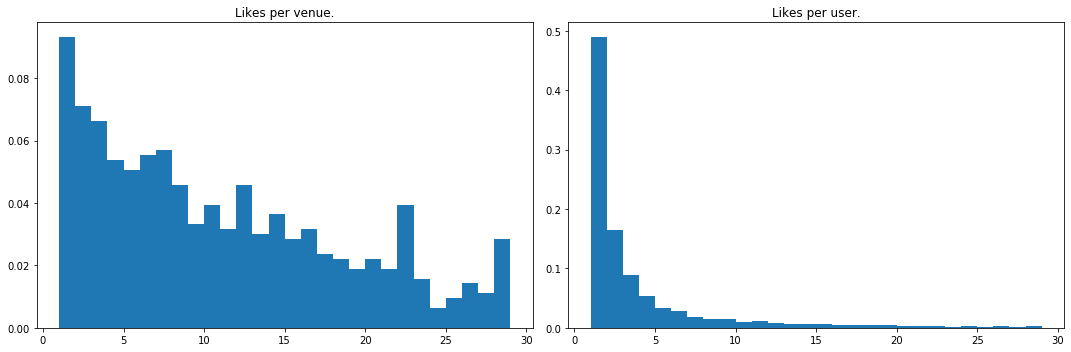

In [923]:
# likes per venue
x1 = pd_venues_likes.groupby('venue_name').count()['user_id']

# likes per user
x2 = pd_venues_likes.groupby('user_name').count()['user_id']

bins = np.arange(1,30)

fig, ax = plt.subplots(1,2,figsize=(15,5))

# the histogram of the data
ax[0].hist(x1, bins, density=1)
ax[0].set_title('Likes per venue.')
ax[1].hist(x2, bins, density = 1)
ax[1].set_title('Likes per user.')


# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In order to recommend restaurants to the InputUser - the user that is inputting his ratings and receiving recommendations - the collaborative filtering algorithm needs to i) compute the similarity score between users and the InputUser and ii) recommend new restaurants that users similar to the InputUser enjoyed (and the InputUser hasn’t been to yet). Thus, we will only use data from users who liked at least one restaurant rated by the InputUser and at least one restaurant that the InputUser hasn’t been to yet. As we can see in the right histogram, about 50% of the users liked only 1 restaurant. It’s likely that we are going to build the collaborative filtering algorithm using data from only a small fraction of users.

## 3.2. Content Based Recomendation System

### 3.2.1. Breaking the data into Train and Test sets

Using the InputUser data, we create the independent variables vector (X) containing the categorical variables we created in section 2.5.1. (price_tier and categories), and the dependant variable vector (y) containing the rating the InputUser has gave to each restaurant:

In [2307]:
# Filtering only restautants I rated.
X = venues_list[venues_list['id'].isin(inputVenues['venue_id'].tolist())]
X.set_index('id', inplace = True)
# Then we filter only the categorical variables
categorical_values = price_list + category_names # List with all the categorical values:
X = X[categorical_values]
y = inputVenues[['rating']]
y.set_index(inputVenues['venue_id'], inplace = True)

Now, let's break the input data into a train and a test set. Further, we will measure the quality of the model with the test set.

In [2441]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state = 1345)
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (78, 128)
y_train.shape = (78, 1)
X_test.shape = (34, 128)
y_test.shape = (34, 1)


### 3.2.2. Calculating user profile

Let’s compute which cuisines and price ranges the InputUser most enjoy.

In [2475]:
def user_profile(X,y, v = 2):
    #Dot produt to get weights
    userProfile = X.transpose().dot(y)
    userProfile['rating'] = userProfile['rating']/X.sum()
    # Compute as a valid variable only if it has been evaluated at least "v" times.
    valid = X.sum() > v
    valid = valid.astype(int)
    userProfile['rating'] = np.round(userProfile['rating']*valid,2)
    userProfile['n_rating'] =  X_train.sum()
    userProfile.replace(np.NaN,0, inplace = True)
    return(userProfile)

userProfile = user_profile(X_train, y_train)
userProfile.sort_values(by = ['rating', 'n_rating'], ascending=False)[0:5]


,rating,n_rating
Japanese Restaurant,4.75,4
Tapas Restaurant,4.67,3
Expensive,4.50,10
Italian Restaurant,4.47,17
Moderate,4.41,27


It looks  like I enjoy Expensive Japanese and Tapas Restaurant.

### 3.2.3. Finding venues that are similar to the ones <i> InputUser</i> liked:

We create a matrix with all the restaurants and multply it by the my user profile ratings:

In [2479]:
def recommendation_table(venues_list, userProfile):
    # filter only categorical values from the complete list of venues
    venues_list_categories = venues_list[categorical_values].set_index(venues_list['id'])
    recommendationTable_df = ((venues_list_categories*userProfile['rating'])).sum(axis=1) # compute the agregate rating for each venue
    pond = (venues_list_categories*valid).sum(axis=1) # pond will be used to average the categorical variables ratings 
    recommendationTable_df = np.round(recommendationTable_df/pond,2)
    return(recommendationTable_df)

recommendationTable_df = recommendation_table(venues_list, userProfile)
recommendationTable_df.sort_values(ascending = False).head(3)
    

id
4a27db33f964a5207f921fe3    4.58
4d5fb655e4fe54810d10779e    4.58
4e99a6f7cc218247d96d2e82    4.58
dtype: float64

Finally, let's put all together and make recommentations:

In [2519]:
def content_based_recommender(X, y, venues, v = 2):
        userProfile = user_profile(X, y, v)
        recommendationTable_df = recommendation_table(venues, userProfile)
        return(recommendationTable_df)

recomendations_cbr = content_based_recommender(X_train, y_train, venues_list, 2)
venues_list.set_index('id').loc[recommendationTable_df.sort_values(ascending = False)[0:5].keys()][['name', 'all_categories', 'price_tier']]

,name,all_categories,price_tier
id,,,
4a27db33f964a5207f921fe3,Umeno,Japanese Restaurant,Moderate
4d5fb655e4fe54810d10779e,"Restaurant ""sato""",Japanese Restaurant,Moderate
4e99a6f7cc218247d96d2e82,Tapas Tia Rosa,Tapas Restaurant,Expensive
52f78dc5498eb24093d7e046,Ku Kitchen & Bar,Japanese Restaurant / Cocktail Bar / Sushi Res...,Moderate
59875f116fd626071da3841c,Blauwe Draak,Japanese Restaurant,Moderate


## 3.3. Colaborative Filtering

The Colaborative Filtering algorithm makes recomendations based on the assumption that users that 

### 3.3.1. Computing Similarity Index

Let's calculate the similarity index for each user in the pd_venues_likes database

In [2516]:
def get_similarity(pd_venues_likes, X, y, v = 2):
    # returns the similarity index for each  user on pd_venuse_likes to the [X,y] matrix
    
    # filters only likes for venues the InputUser rated
    filetered_venues_likes = pd_venues_likes[pd_venues_likes['venue_id'].isin(X.index)] # X_train has the categorical values for part of the venues I rated
    # put my rating in the dataframe
    filetered_venues_likes = pd.merge(filetered_venues_likes, y['rating'], left_on = 'venue_id', right_on = 'venue_id', how = "left") # y_train has the rating I gave for these venues
    
    # buliding the similarity dateframe
    similarity = filetered_venues_likes.groupby('user_id').mean()
    similarity.rename(columns = {'rating': 'similarity'}, inplace = True)
    similarity['numb_ratings'] =filetered_venues_likes.groupby('user_id').count()['user_name']
    # filters only users that have at least 2 likes for restaurants rated by the input user
    x = 2
    similarity = similarity[similarity.numb_ratings >= x]
    similarity.reset_index(inplace=True)
    similarity['similarity'] = np.round(similarity['similarity'],2)
    return(similarity)


similarity = get_similarity(pd_venues_likes, X_train, y_train, v = 2)


### 3.3.2. Selecting recommended venues

Now, we incorporate the similarity score for each user into the venues_likes dataframe. Then, for each venue, we average the similarity score of users that liked them.

In [2522]:
def collaborative_filtering_recommender(X, y, likes, v = 2):
    similarity = get_similarity(likes, X, y, v)
    pd_vl_similarity = pd.merge(likes, similarity, how = "right") # right merge to only take into account likes from users that have similarity score computed
    pd_vl_similarity.drop('numb_ratings', axis=1, inplace=True)
    recommendationTable = pd_vl_similarity.groupby('venue_id').mean().sort_values(by = 'similarity', ascending = False)
    return(recommendationTable)

recommendations_cfr = collaborative_filtering_recommender(X_train, y_train, pd_venues_likes, v=2)
venues_list.set_index('id').loc[recommendations_cfr.index].head(5)[['name', 'all_categories', 'price_tier']]


,name,all_categories,price_tier
venue_id,,,
4a27033af964a520ce841fe3,Restaurant Freud,Restaurant,Moderate
4a2703dbf964a520a1851fe3,Affourtit,French Restaurant / Bistro,Expensive
4a2707b1f964a520998e1fe3,Perla di Roma,Italian Restaurant,Moderate
4b4f5182f964a520190127e3,Erol Doner,Turkish Restaurant,Moderate
55c49159498e653f9ec81f5d,Kurio's,Turkish Restaurant / Café,Moderate


### 4.5 - Computing Model Error

In [2561]:
import sklearn.metrics as metrics

# Content-based
recommendationTable_cbr = content_based_recommender(X_train, y_train, venues_list, 2)
y_hat_cbr = recommendationTable_cbr.loc[X_test.index]
RSME_cbr = np.round(metrics.mean_squared_error(y_test, y_hat_cbr, squared = False),2)
r2_cbr = np.round(r2_score(y_test,y_hat_cbr),2)

# Collaborative Filtering
recommendationTable_cfr = collaborative_filtering_recommender(X_train, y_train, pd_venues_likes, v=2)
y_hat_cfr = recommendationTable_cfr.loc[X_test.index]
# We cannot classify all the test set. Thus, let's drop these values from the dataset in order to compute the error only for values we were able to calculate the  error.
nans_index = y_hat_cfr.isnull()
nans_index = nans_index[nans_index['similarity'] == True].index
y_hat_cfr = y_hat_cfr.drop(nans_index)
RSME_cfr = np.round(metrics.mean_squared_error(y_test.drop(nans_index), y_hat_cfr, squared = False),2)
r2_cfr = np.round(r2_score(y_test.drop(nans_index),y_hat_cfr),2)

error_df = pd.DataFrame({'RSME' : [RSME_cbr, RSME_cfr], 'r_squared' : [r2_cbr, r2_cfr], 'valid_samples': [y_hat_cbr.shape[0], y_hat_cfr.shape[0]]}, index = ['Content-Based', 'Collaborative Filtering'])
error_df

<ipython-input-2561-7f741c56293f>:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  y_hat_cfr = recommendationTable_cfr.loc[X_test.index]


,RSME,r_squared,valid_samples
Content-Based,0.62,0.76,34
Collaborative Filtering,1.21,0.15,24


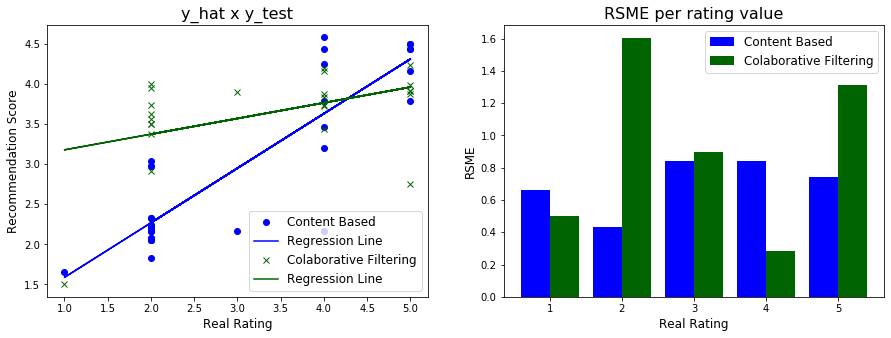

In [2562]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

y_test_new = y_test.drop(nans_index)

# Plot 1:

ax[0].set_title('y_hat x y_test', fontsize = 16)

# Content Based
# Scatter
ax[0].plot(y_test,y_hat_cbr,'o', color = 'b')
# Regression Line
m, b = np.polyfit(y_test['rating'], y_hat_cbr, 1)
ax[0].plot(y_test['rating'], m*y_test['rating'] + b, c = 'b')

# Collaborative Filtering
# Scatter
ax[0].plot(y_test_new,y_hat_cfr,'x', color = 'darkgreen')
# Regression Line
m, b = np.polyfit(y_test_new['rating'], y_hat_cfr, 1)
ax[0].plot(y_test_new['rating'], m*y_test_new['rating'] + b, c = 'darkgreen')


ax[0].legend(['Content Based', 'Regression Line', 'Colaborative Filtering', 'Regression Line'], fontsize = 12)
ax[0].set_xlabel("Real Rating", fontsize = 12)
ax[0].set_ylabel("Recommendation Score" , fontsize = 12)



#Plot 2:
ax[1].set_title('RSME per rating value', fontsize = 16)

# Content Based
RSME_cbr = np.zeros(5)
for r in np.arange(1,6):
    y_test2 = y_test[y_test['rating'] == r]
    y_hat2 = y_hat_cbr[y_hat_cbr.index.isin(y_test2.index.tolist())]
    RSME_cbr[r-1] = metrics.mean_squared_error(y_test2, y_hat2, squared = False)
    

# Collaborative Filtering
RSME_cfr = np.zeros(5)
for r in np.arange(1,6):
    y_test2 = y_test_new[y_test_new['rating'] == r]
    y_hat2 = y_hat_cfr[y_hat_cfr.index.isin(y_test2.index.tolist())]
    RSME_cfr[r-1] = metrics.mean_squared_error(y_test2, y_hat2, squared = False)
    
# Ploting
ax[1].bar([1,2,3,4,5],RSME_cbr, color = 'b', width = -0.4, align = 'edge')
ax[1].bar([1,2,3,4,5],RSME_cfr, color = 'darkgreen', width = +0.4, align = 'edge')
ax[1].set_xlabel("Real Rating", fontsize = 12)
ax[1].set_ylabel("RSME", fontsize = 12)
ax[1].legend(['Content Based', 'Colaborative Filtering'], fontsize = 12)


In [2103]:
n = 10
#cat = 'Japanese Restaurant'
pt = 'Moderate'
cbr = venues_list.set_index('id').loc[recommendationTable_df.sort_values(ascending = False).keys()][['name', 'main_category', 'price_tier']]
#cbr = cbr[cbr['main_category'] == cat]
cbr = cbr[cbr['price_tier'] == pt]
cbr = cbr[0:n]
cfr = venues_list.set_index('id').loc[recommendationTable_cf.index][['name', 'main_category', 'price_tier']]
#cfr = cfr[cfr['main_category'] == cat]
cfr = cfr[cfr['price_tier'] == pt]
cfr = cfr[0:n]
a = cbr.reset_index()[['name', 'main_category']].rename(columns = {'name': 'content_based'})
b = cfr.reset_index()[['name','main_category']].rename(columns = {'name': 'collab_filtering','main_category' : 'main_category_b' })
a.join(b)

,content_based,main_category,collab_filtering,main_category_b
0,Umeno,Japanese Restaurant,Beymen café & restaurant,Turkish Restaurant
1,"Restaurant ""sato""",Japanese Restaurant,Oishii Sushi,Japanese Restaurant
2,Ku Kitchen & Bar,Japanese Restaurant,Bar Sue,Asian Restaurant
3,Blauwe Draak,Japanese Restaurant,Dappertutto,Italian Restaurant
4,Ayumi,Japanese Restaurant,Sen Viet,Vietnamese Restaurant
5,Teppanyaki Restaurant Sazanka,Japanese Restaurant,Bagels & Beans,Bagel Shop
6,EN Japanese Kitchen @ Sake Bar,Japanese Restaurant,Ava Cyrill İtaliaans Restaurant,Italian Restaurant
7,Taste of Okura,Japanese Restaurant,Sushi Day,Sushi Restaurant
8,Onigiri Ya!,Japanese Restaurant,Sushilee,Japanese Restaurant
9,De Japanner,Japanese Restaurant,Soytasty,Sushi Restaurant
